In [121]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

원본 이미지 로드 및 전처리

In [128]:
img = cv2.imread('baby.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape

(2876, 2924, 3)

In [129]:
# 이미지가 나누어 떨어지게끔

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 0:sz[1]]
    return img

img = modcrop(img, 30)
img.shape

def shave(image, border):
    img = image[border:-border, border:-border]
    return img

img.shape

(2850, 2910, 3)

downgraded

In [133]:
factor = 30
h, w, c = img.shape
new_width = int(w / factor)
new_height = int(h / factor)

downgraded_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)  # downgraded
downgraded_img = cv2.resize(downgraded_img, (w, h), interpolation=cv2.INTER_LINEAR)  # downgraded한 것을 원래의 w, h로 복원

downgraded_img.shape

(2850, 2910, 3)

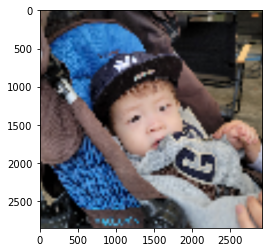

In [134]:
plt.imshow(downgraded_img)

원본과 비교

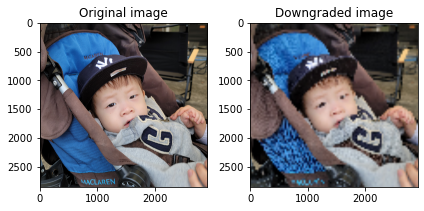

In [135]:
fig = plt.figure()
rows = 1; cols = 2

ax1 = fig.add_subplot(rows, cols, 1)
ax1.set_title('Original image')
ax1.imshow(img)

ax2 = fig.add_subplot(rows, cols, 2)
ax2.set_title('Downgraded image')
ax2.imshow(downgraded_img)

fig.tight_layout()
plt.show()

In [112]:
downgraded_img = cv2.cvtColor(downgraded_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('downgraded_baby.jpg', downgraded_img)

True

모델링

In [113]:
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # compile model
    SRCNN.compile(optimizer='adam', loss='mse', metrics=['mse'])
    
    return SRCNN


예측

In [119]:
def predict(image_path):
    
    # load the SRCNN model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    ref = cv2.imread('baby.jpg')
    degraded = cv2.imread(image_path)

    
    # preprocess the image with madcrop
    ref = modcrop(ref, 10)
    degraded = modcrop(degraded, 10)
    
    # convert the image to VCrCb - (srccn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=100)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR) 
    
    # remove border from reference and degraded image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # return images and scores
    return ref, degraded, output
    

In [120]:
ref, degraded, output = predict('downgraded_baby.jpg')

# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20,8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original")
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title("Degraded")
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title("SRCNN")

# remove the x and y tick marks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

ResourceExhaustedError:  OOM when allocating tensor with shape[1,64,2862,2912] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_7/conv2d_19/Relu
 (defined at C:\ProgramData\Anaconda3\lib\site-packages\keras\backend.py:4867)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_953]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_7/conv2d_19/Relu:
In[0] sequential_7/conv2d_19/BiasAdd (defined at C:\ProgramData\Anaconda3\lib\site-packages\keras\layers\convolutional.py:264)

Operation defined at: (most recent call last)
>>>   File "C:\ProgramData\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\bitcamp\AppData\Local\Temp/ipykernel_18312/490285943.py", line 1, in <module>
>>>     ref, degraded, output = predict('downgraded_baby.jpg')
>>> 
>>>   File "C:\Users\bitcamp\AppData\Local\Temp/ipykernel_18312/755775410.py", line 24, in predict
>>>     pre = srcnn.predict(Y, batch_size=100)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1789, in predict
>>>     tmp_batch_outputs = self.predict_function(iterator)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1621, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1611, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1604, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 273, in call
>>>     return self.activation(outputs)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\activations.py", line 311, in relu
>>>     return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
>>> 
>>>   File "C:\ProgramData\Anaconda3\lib\site-packages\keras\backend.py", line 4867, in relu
>>>     x = tf.nn.relu(x)
>>> 